In [1]:
print("test,world")

test,world


In [2]:
import os
import tarfile
import urllib

In [3]:
HOUSING_ROOT="https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH=os.path.join("datasets","housing")
HOUSING_URL=HOUSING_ROOT+"datasets/housing/housing.tgz"

In [4]:
# def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
#     os.makedirs(housing_path,exist_ok=True)
#     tgz_path=os.path.join(housing_path,"housing.tgz")
#     urllib.request.urlretrieve(housing_url,tgz_path)
#     housing_tgz=tarfile.open(tgz_path)
#     housing_tgz.extractall(path=housing_path)
#     housing_tgz.close()

In [5]:
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
    os.makedirs(housing_path,exist_ok=True)
    tgz_path=os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(housing_path)
    housing_tgz.close()
    

In [6]:
import pandas as pd

In [7]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [8]:
fetch_housing_data()

/tmp/ipykernel_628485/4004278275.py:6: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(housing_path)


In [9]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
import numpy as np


In [11]:
def split_train_test(data,test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_set=shuffled_indices[:test_set_size]
    train_set=shuffled_indices[test_set_size:]
    return data.iloc[train_set],data.iloc[test_set]

In [12]:
train_set, test_set = split_train_test(housing,0.2)

In [13]:
len(train_set)

16512

In [14]:
len(test_set)

4128

# Instance Identifier-
- A label or unique value to distinguish one set of data from another

In [15]:
from zlib import crc32

In [16]:
def test_set_check(identifier,test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff <test_ratio* 2**32

In [17]:
def split_train_test_by_id(data,test_ratio,id_column):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_:test_set_check(id_,test_ratio))
    return data.loc[~in_test_set],data.loc[in_test_set]

In [18]:
housing_with_id=housing.reset_index()

In [19]:
train_set,test_set=split_train_test_by_id(housing_with_id,0.2,"index")

# Drawbacks of using index as an instance idetifierd

we have to make sure that new data gets appended to the end of the dataset and no row ever gets deleted.

If this is not possible then one of things we can do is to use one of the stable feautres to build a unique identifier.
For exammple in this case we can use a district's latitude and longitude as an unique identifier cause it is not going to change in a few million of so.

In [20]:
housing_with_id["id"] =housing["longitude"]*1000+ housing["latitude"]
train_set,test_set=split_train_test_by_id(housing_with_id,0.2,"id")

# Scikit-learn Function to split training and testing set
- simplest function is `train_test_split()` -> it exactly does the same things as our `train_test_split` with a couple of additional feature like we can provide `random_state` parameter which allows us to set the random generator seed and other is we can pass it multiple datasets with an identical number of rows and it will split them on the same indices.
- The second feature is very helpful if we have separate DataFrame for labels.
## Below is the example of train_test_split() from the scikit learn

In [21]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)

# Stratified Smapling
- A way of spliting the dataset so that important proportions are preserved in both training set and testing set.
## Strata
- division of population of data in homogeneous subgroup is call **strata**.
- The right no of instances are sampled from each **stratum** to guarantee that the test set is representative of the overall population.

In [22]:
housing["income_cat"]=pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])

<Axes: >

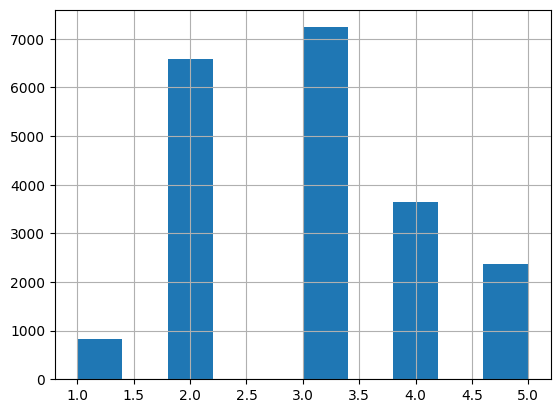

In [23]:
housing["income_cat"].hist()

# An example code for Stratified Shuffle

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

`n_splits`: it controls the number of time the datasets will be shuffled and split

In [25]:
splits = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

In [26]:
for train_index,test_index in splits.split(housing,housing["income_cat"]):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]

Now we need to drop the `income_cat` attribute so that the data is back to its original state

In [27]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

# Visualization of Data to Gain Insights

In [28]:
housing=strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

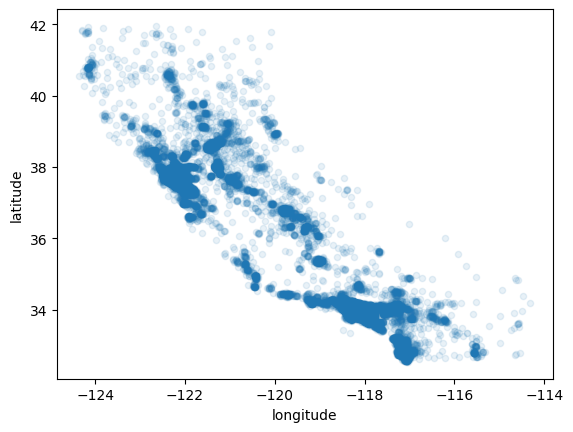

In [29]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)

In [30]:
import matplotlib.pyplot as plt

<Axes: xlabel='longitude', ylabel='latitude'>

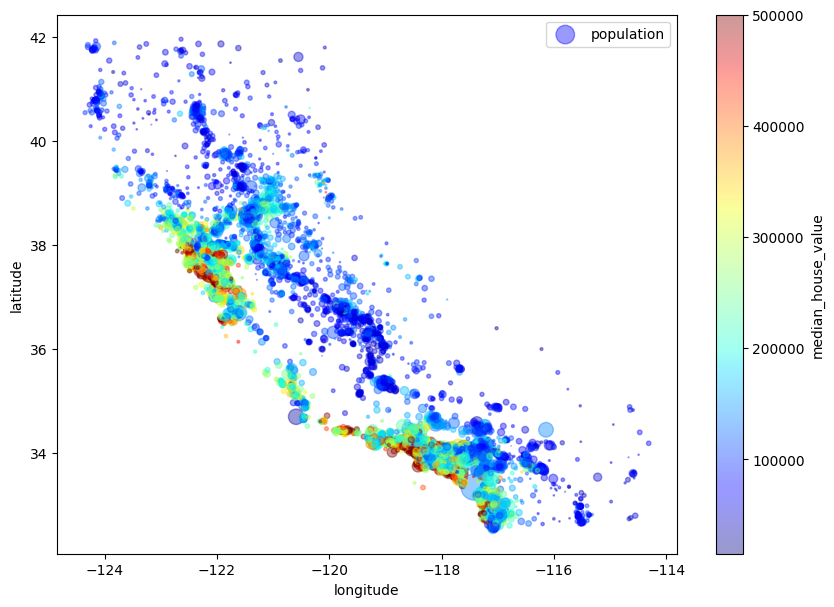

In [31]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4, s=housing["population"]/100,label="population",figsize=(10,7),c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)

# Looking For Correlations

# What is Corr()
- The `.corr()` method in Python is a pandas DataFrame function use to compute the pairwise correlation of column.
- by default `.corr()` calculates the **Pearson Correlation Coefficient** , which is a value between 1 and -1.
- A value of 1 indicate perfect positive linear relationship: as one column value increases the other column value increases proportionally.
- A value of -1 indicate perfect negative linear relationship: as one column value increases the other column value decreases proportionally.
- A value of 0 indicate no linear relationship between the columns.

In [32]:
corr_matrix=housing.drop("ocean_proximity",axis=1).corr()

In [33]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

# Pandas Scatter Matrix
- it plots every numerical attributes against every other numerical attribute.

In [34]:
from pandas.plotting import scatter_matrix

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

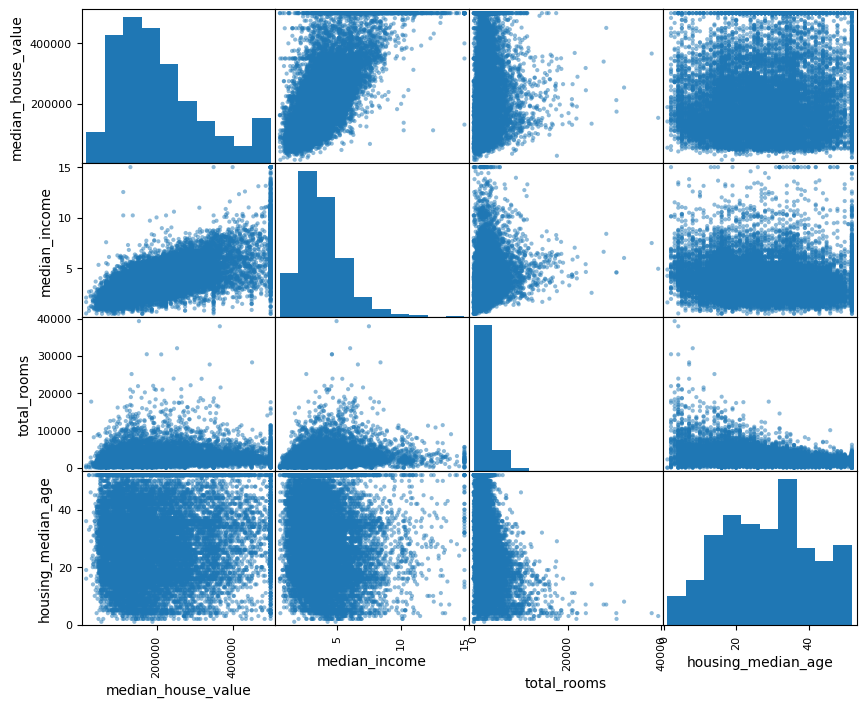

In [35]:
attributes=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(10,8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

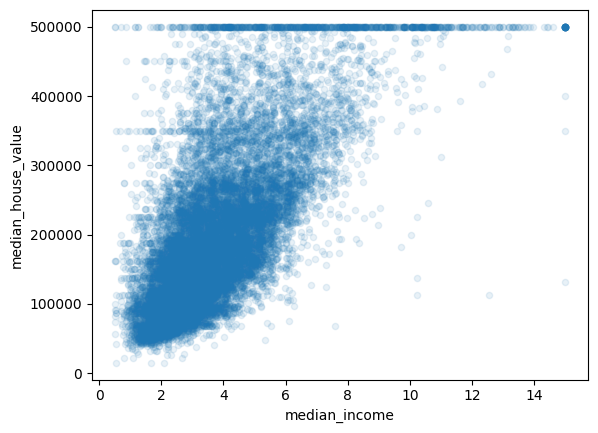

In [36]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

# Creating Some new attribute

In [37]:
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_household"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [38]:
corr_matrix=housing.drop("ocean_proximity",axis=1).corr()

In [39]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_household     -0.259952
Name: median_house_value, dtype: float64

# Now we have to clean the data for machine learning algorithm
for that we have to separate predictors and the labels since we don't necessarily want to apply the same transformations to the predictor and the labels.

In [40]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_label=strat_train_set["median_house_value"].copy()

# Data Cleaning
- Most machine learning algoritm can not work with missing data. So we can do either of these following things:
1. Get rid of the corresponding districts
2. Get rid of the whole value
3. set the values to some value(zero,the mean,the median etc)

# Scikit Learn - SimpleImputerFunction
- It is used to calculate the missing value in a dataset and replaces those missing value with the calculated one such as mean ,median ,mode of the column.
## Key attributes and parameter
1. `missing_values`- This parameter specifies what value in the data set should be treated as missing like nan ,"" ,0;
2. `strategy`- it defines how the missing value will be replaced.
   - like `mean` , `median`,`most_frequent`,`constant`,
3. `fill_value` - this attributes is used when strategy is set to constant . we need to provide the constant value for the imputation.

In [41]:
from sklearn.impute import SimpleImputer

In [42]:
imputer = SimpleImputer(strategy="median")

medina can only be computed on numerical attributes so we need to drop `ocean_proximity` attributes which is a text attribute;

In [43]:
housing_num=housing.drop("ocean_proximity",axis=1)

In [44]:
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [45]:
imputer.statistics_


array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [46]:
housing_num.median().values


array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [47]:
X = imputer.transform(housing_num)

## The result of transform will be a numpy array containing the transform feature so we can convert it into pandas DataFrame.

In [48]:
housing_tr=pd.DataFrame(X,columns=housing_num.columns, index=housing_num.index)

# Scikit Learn Design


In [49]:
housing_cat=housing[["ocean_proximity"]]

In [50]:
housing_cat.head()

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


# Ordinal Encoder
- converts the categories from text to numbers

In [51]:
from sklearn.preprocessing import OrdinalEncoder

In [52]:
ordinal_encoder=OrdinalEncoder()
housing_cat_encoded=ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

#### we can get the list of categories using the `categories_` instance varible

In [53]:
ordinal_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### One of the issue with this representation is that ML algorithm will assume that two nearby values are more similar that two distant values.
#### To fix this issue we can create binary attribute per category. This is called **OneHotEncoding**.

In [54]:
from sklearn.preprocessing import OneHotEncoder

In [55]:
cat_encoder=OneHotEncoder()
housing_cat_one_hot=cat_encoder.fit_transform(housing_cat)
housing_cat_one_hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

#### The output of this is SciPy sparse matrix, instead of a NumPy array.
#### The sparse matrix store only the location of nonzero elements saving ton of memory mostly to store zeros.

#### we can get the list of categories using the encoder's categories_ instance variable;

In [56]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### NOTE: If the categorical attribute has a large number of possible categories then one-hot encoding will result in large number of input feature which may slow down the training process and degrade performance. If this happens, we may want to replace categorical data with useful numerical feature related to categories. Alternatively we could replace each categories with a learnable, low dimensional vector called *embedding*. Each categories representation would be learned during training. This is also called **Representation Learning**.

# Custom Transformer
- we may need to write our own transformer for custom cleanup operation or commbining specific attributes.
- Scikit-learn relies on duck typing. All we need to do to create custom transformer is to create a class and implement three methods: `fit()`(returning self), `transform()` and `fit_transform()`.
- we will get last one for free by simply adding `TransformerMixin` as a base class.
- And if we add `BaseEstimator` as a base class we will get two extra methods `get_param()` and `set_params()` which will be useful for automatic hyperparameter tuning.

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin
room_ix,bedrooms_ix,population_ix,households_ix=3,4,5,6


class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        rooms_per_household=X[:, room_ix]/X[:,households_ix]
        population_per_household= X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,room_ix]
            return np.c_[X, rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household,population_per_household]



In [80]:
attr_adder=CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs=attr_adder.transform(housing.values)

# Feature Scaling
- with few exceptions, machine learning algorithms don't perform well when the input numerical attributes have very different scales. Scaling the terget value is generally not required.
- There are two common ways to get all the attribute to have the same scale: `min-max scaling` and `standardization`

## Min-max Scaling aka normalization
- it is simplest. Values are shifte and rescaled so that they end up ranging from 0 to 1.
- we do this by subtracting the min value and the dividing by the max minus the min.
- Scikit-learn has a transformer called ```MinMaxScalar``` and it has a ```feature_range``` hyperparameter that lets us change the range if we don't want the range to be 0 to 1. 

## Standardization
- first it subtracts the mean value so that standardized values always have a zero mean the it divides by the standard deviation so that the resulting distribution has unit variance.
- Unlike min-max scaling, standardization does not bound values to a specific range, which may be the problem for some ML algorithm(i.e neural network)
- It is much less effected by the outliers.

# Transformation Pipelines
- pipelines is a powerful tool for chaining multiple data processing step and a machine learning model into single cohesive object. It is used to automate the workflow and prevent data leakage and make code more cleaner and reproducible.
- 

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [82]:
num_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr=num_pipeline.fit_transform(housing_num)

In [83]:
from sklearn.compose import ColumnTransformer

In [84]:
num_attribs=list(housing_num)
cat_attribs=["ocean_proximity"]

full_pipeline=ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat",OneHotEncoder(),cat_attribs),
])

In [85]:
housing_prepared=full_pipeline.fit_transform(housing)